# ALGORITMO GENETICO PARA VEHICLE ROUTING PROBLEM (VRP)
## Tesis de Maestría - Optimizacion de Rutas de Transporte

---

## TABLA DE CONTENIDOS

1. **Paso 0: Descripcion del Sistema** <- Estás aquí
2. **Paso 1: Librerías**
3. **Paso 2: Carga de Datos**
4. Paso 3: Análisis de Datos
5. Paso 4: Configuración del GA
6. Paso 5: Operadores Genéticos
7. Paso 6: Ejecución del GA
8. Paso 7: Intensificación y Búsqueda Local
9. Paso 8: Resultados y Comparativas

---

# PASO 0: DESCRIPCION DEL SISTEMA

## Problema: Vehicle Routing Problem (VRP)

### Objetivo General
Encontrar un conjunto de rutas óptimas para una flota de camiones que deben entregar y recoger mercancía en múltiples clientes, minimizando costos operacionales mientras se respetan todas las restricciones del sistema.

### Contexto Operacional
- **Flota**: 7 camiones heterogéneos
- **Clientes**: 14 clientes (más depósito central)
- **Franjas Horarias**: 10 franjas de tráfico con velocidades variables
- **Ventanas Horarias**: Cada cliente tiene horarios específicos de atención
- **Tipos de Contrato**: Por hora, franja 6h, franja 12h

---

## HEURISTICA ESCOGIDA: ALGORITMO GENETICO

### Justificación
Se utiliza un Algoritmo Genético porque:
1. **Complejidad del problema**: VRP es NP-hard, requiere metaheurísticas
2. **Múltiples restricciones**: El GA maneja bien problemas con restricciones complejas
3. **Diversidad de soluciones**: Puede encontrar múltiples soluciones viables
4. **Escalabilidad**: Funciona bien con flota heterogénea y ventanas de tiempo

### Características del GA Propuesto
- Población: **100 individuos**
- Generaciones: **500 máximo**
- Parada anticipada: **60 generaciones sin mejora**
- Elitismo: **2 individuos** pasan intactos
- Tasa de cruce: **85%**
- Tasa de mutación: **10%**

---

## OPERADOR DE MUTACION

### Mutación Estructurada
La mutación propuesta respeta la estructura del vector:

**Pasos:**
1. **Seleccionar punto de corte** aleatorio en el vector
2. **Copiar segmento** del padre A desde el punto de corte
3. **Rellenar con clientes faltantes** del padre B en el orden original
4. **Reinsertar separadores (1)** manteniendo la cantidad de camiones

### Tipos de Mutación
- **SWAP (70%)**: Intercambiar dos clientes dentro del vector
- **INSERT (20%)**: Mover un cliente de una ruta a otra
- **No mutación (10%)**: El individuo pasa sin cambios

### Ejemplo SWAP
```
Antes:  [1, 3, 5, 7, 1, 2, 4, 6, 1, 8, 9, 10]
Despues:[1, 5, 3, 7, 1, 2, 4, 6, 1, 8, 9, 10]  (intercambia 3 y 5)
```

### Ejemplo INSERT
```
Antes:  [1, 3, 5, 7, 1, 2, 4, 6, 1, 8, 9, 10]
Despues:[1, 3, 5, 1, 2, 4, 6, 7, 1, 8, 9, 10]  (mueve 7 de camión 1 a camión 2)
```

---

# PASO 1: LIBRERIAS

En esta sección se importan todas las librerías necesarias para la implementación del Algoritmo Genético.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')
import time
from collections import defaultdict

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print('Librerias importadas exitosamente')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Matplotlib version: {plt.matplotlib.__version__}')

Librerias importadas exitosamente
NumPy version: 2.3.2
Pandas version: 2.3.1
Matplotlib version: 3.10.3


---

# PASO 2: CARGA DE DATOS

En esta sección se cargan los datos del archivo .dat y se estructura la información en diccionarios accesibles para el algoritmo.

## Definición de ruta de datos

La ruta de datos es una variable que puede ser modificada fácilmente si los datos cambian de ubicación.

In [27]:
# RUTA DE DATOS (PUEDE CAMBIAR)
DATA_PATH = r"C:\Users\sjaim\OneDrive\Escritorio\Sebastián Jaimes\Tesis\Datos SEBAS 4 CAMIONES 14 CLIENTES  6 FRANJAS .dat"
print(f'Ruta de datos: {DATA_PATH}')
print('Nota: Esta ruta puede ser modificada si los datos cambian de ubicación')

Ruta de datos: C:\Users\sjaim\OneDrive\Escritorio\Sebastián Jaimes\Tesis\Datos SEBAS 4 CAMIONES 14 CLIENTES  6 FRANJAS .dat
Nota: Esta ruta puede ser modificada si los datos cambian de ubicación


## Funciones de parseo del archivo .dat

In [28]:
def parse_ampl_param(line: str) -> Tuple[str, any]:
    """
    Parsea una línea de parámetro AMPL.
    
    Formatos soportados:
    - param nombre := valor;
    - param nombre := valor1 valor2 ...;
    - param nombre := indice1 valor1 indice2 valor2 ...;
    """
    if 'param' not in line:
        return None, None
    
    # Extraer nombre del parámetro
    parts = line.split(':=')
    if len(parts) != 2:
        return None, None
    
    param_name = parts[0].replace('param', '').strip()
    values_str = parts[1].replace(';', '').strip()
    
    return param_name, values_str

def parse_dat_file(filepath: str) -> Dict:
    """
    Parsea un archivo .dat de AMPL y retorna un diccionario con todos los parámetros.
    """
    data = {}
    
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Separar por parámetros
    lines = content.split('\n')
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        if not line or line.startswith('#'):
            i += 1
            continue
        
        if 'param' in line:
            # Parámetro simple o con índices
            param_name = line.split()[1].split(':=')[0]
            
            # Buscar el cierre del parámetro
            full_param = line
            while ';' not in full_param and i < len(lines) - 1:
                i += 1
                full_param += ' ' + lines[i].strip()
            
            # Procesar parámetro
            if ':=' in full_param:
                values_part = full_param.split(':=')[1].replace(';', '').strip()
                
                # Intentar parsear como tabla 2D
                if ':' in values_part and param_name in ['Dist', 'tvia']:
                    data[param_name] = parse_matrix_param(values_part, param_name)
                else:
                    # Parámetro 1D
                    data[param_name] = parse_simple_param(values_part)
        
        i += 1
    
    return data

def parse_simple_param(values_str: str) -> Dict:
    """
    Parsea un parámetro simple de la forma: indice1 valor1 indice2 valor2 ...
    """
    tokens = values_str.split()
    result = {}
    
    i = 0
    while i < len(tokens) - 1:
        try:
            key = int(tokens[i])
            value = float(tokens[i + 1])
            result[key] = value
            i += 2
        except (ValueError, IndexError):
            i += 1
    
    return result

def parse_matrix_param(values_str: str, param_name: str) -> Dict:
    """
    Parsea una matriz de parámetros 2D o 3D.
    Formato: [*,*,franja]: i j val i j val ...
    """
    result = {}
    
    # Buscar secciones por franja
    sections = values_str.split('[*,*,')
    
    for section in sections:
        if not section.strip():
            continue
        
        # Para matrices 2D simples (Dist)
        if 'Dist' in param_name:
            tokens = section.split()
            i = 0
            row = None
            while i < len(tokens):
                try:
                    val = int(tokens[i])
                    if row is None:
                        row = val
                    else:
                        col = val
                        if row not in result:
                            result[row] = {}
                        i += 1
                        result[row][col] = float(tokens[i])
                        row = None
                    i += 1
                except (ValueError, IndexError):
                    i += 1
        else:
            # Para matrices 3D (tvia)
            parts = section.split(':')
            if len(parts) > 0:
                franja_str = parts[0].strip()
                try:
                    franja = int(franja_str)
                    if len(parts) > 1:
                        data_part = parts[1].strip()
                        if franja not in result:
                            result[franja] = {}
                        result[franja] = parse_matrix_2d(data_part)
                except ValueError:
                    pass
    
    return result

def parse_matrix_2d(data_str: str) -> Dict:
    """
    Parsea una matriz 2D en formato AMPL.
    """
    result = {}
    tokens = data_str.split()
    
    i = 0
    row = None
    while i < len(tokens):
        try:
            val = int(tokens[i])
            if row is None:
                row = val
            else:
                col = val
                if row not in result:
                    result[row] = {}
                i += 1
                result[row][col] = float(tokens[i])
                row = None
            i += 1
        except (ValueError, IndexError):
            i += 1
    
    return result

print('Funciones de parseo definidas correctamente')

Funciones de parseo definidas correctamente


## Carga y estructuración de datos

In [29]:
# Cargar datos
print('Cargando datos del archivo .dat...')
raw_data = parse_dat_file(DATA_PATH)
print(f'Cantidad de parámetros cargados: {len(raw_data)}')
print(f'Parámetros: {list(raw_data.keys())[:10]}...')

Cargando datos del archivo .dat...
Cantidad de parámetros cargados: 32
Parámetros: ['escliente', 'esdepo', 'escritico', 'esHora', 'esF6', 'esF12', 'Cap', 'CH', 'CF6', 'CF12']...


## Estructura de datos principal

In [30]:
# Crear estructura de datos accesible
class DataVRP:
    """
    Clase que contiene todos los datos del problema VRP.
    Facilita el acceso a parámetros, demandas, ventanas, etc.
    """
    
    def __init__(self, raw_data: Dict):
        # Parámetros binarios
        self.escliente = raw_data.get('escliente', {})
        self.esdepo = raw_data.get('esdepo', {})
        self.escritico = raw_data.get('escritico', {})
        self.esHora = raw_data.get('esHora', {})
        self.esF6 = raw_data.get('esF6', {})
        self.esF12 = raw_data.get('esF12', {})
        
        # Capacidades y costos
        self.Cap = raw_data.get('Cap', {})
        self.CH = raw_data.get('CH', {})
        self.CF6 = raw_data.get('CF6', {})
        self.CF12 = raw_data.get('CF12', {})
        
        # Penalizaciones
        self.pcmin_c = raw_data.get('pcmin_c', {}).get(0, 10)
        self.pcmax_c = raw_data.get('pcmax_c', {}).get(0, 15)
        self.pcmin_nc = raw_data.get('pcmin_nc', {}).get(0, 5)
        self.pcmax_nc = raw_data.get('pcmax_nc', {}).get(0, 8)
        self.preg = raw_data.get('preg', {}).get(0, 20)
        self.pant = raw_data.get('pant', {}).get(0, 0)
        
        # Demandas
        self.DemE = raw_data.get('DemE', {})
        self.DemR = raw_data.get('DemR', {})
        
        # Tiempos de servicio
        self.TS = raw_data.get('TS', {})
        
        # Ventanas de tiempo
        self.MinDC = raw_data.get('MinDC', {})
        self.MaxDC = raw_data.get('MaxDC', {})
        
        # Distancias
        self.Dist = raw_data.get('Dist', {})
        
        # Velocidades y franjas
        self.v = raw_data.get('v', {})
        self.tinic = raw_data.get('tinic', {})
        self.tfin = raw_data.get('tfin', {})
        self.tvia = raw_data.get('tvia', {})
        
        # Parámetros de muelles
        self.nmuelles = raw_data.get('nmuelles', {}).get(0, 2)
        self.durH = raw_data.get('durH', {}).get(0, 0.166)
        self.Lc = raw_data.get('Lc', {}).get(0, 3)
        self.tcarga = raw_data.get('tcarga', {}).get(0, 0.5)
        self.M = raw_data.get('M', {}).get(0, 9999)
        self.pw = raw_data.get('pw', {}).get(0, 10000)
        
        # Constantes
        self.depo = 0
        self.tlim = 18.0
        self.alm = 14.0
        self.talm = 1.0
        self.tminsal = 0.0
        
        # Derivar información
        self.num_trucks = len([k for k in self.esHora.keys() if isinstance(k, int)])
        self.num_clients = len([k for k in self.escliente.keys() if self.escliente.get(k, 0) == 1])
        self.num_time_windows = len(self.tinic)
    
    def get_distance(self, i: int, j: int) -> float:
        """Obtener distancia entre nodos i y j"""
        # Manejar Dist como diccionario anidado
        if isinstance(self.Dist, dict):
            if i in self.Dist:
                dist_i = self.Dist[i]
                if isinstance(dist_i, dict) and j in dist_i:
                    return dist_i[j]
        # Si no encuentra, retorna distancia euclidiana aproximada (por defecto 50 km)
        return 50.0 if i != j else 0.0
    
    def get_travel_time(self, i: int, j: int, franja: int) -> float:
        """Obtener tiempo de viaje entre nodos i y j en la franja f"""
        if franja in self.tvia and i in self.tvia[franja] and j in self.tvia[franja][i]:
            return self.tvia[franja][i][j]
        return 0.0
    
    def is_critical(self, client: int) -> bool:
        """Determinar si un cliente es crítico"""
        return self.escritico.get(client, 0) == 1

# Instanciar objeto de datos
vrp_data = DataVRP(raw_data)

print('Estructura de datos cargada exitosamente')
print(f'Número de camiones: {vrp_data.num_trucks}')
print(f'Número de clientes: {vrp_data.num_clients}')
print(f'Número de franjas horarias: {vrp_data.num_time_windows}')
print(f'Número de muelles: {vrp_data.nmuelles}')
print(f'Límite de tiempo de regreso: {vrp_data.tlim}:00')
print(f'Hora de almuerzo: {vrp_data.alm}:00')

Estructura de datos cargada exitosamente
Número de camiones: 4
Número de clientes: 14
Número de franjas horarias: 6
Número de muelles: 2
Límite de tiempo de regreso: 18.0:00
Hora de almuerzo: 14.0:00


## Validación de datos cargados

In [31]:
# Validar que todos los datos esenciales estén presentes
essential_params = [
    'escliente', 'esdepo', 'Cap', 'CH', 'CF6', 'CF12',
    'DemE', 'DemR', 'TS', 'MinDC', 'MaxDC', 'Dist'
]

missing = []
for param in essential_params:
    if not hasattr(vrp_data, param) or len(getattr(vrp_data, param)) == 0:
        missing.append(param)

if missing:
    print(f'Advertencia: Los siguientes parámetros están faltando: {missing}')
else:
    print('Todos los parámetros esenciales cargados correctamente')

# Mostrar ejemplo de datos
print('\nEjemplo de capacidades de camiones:')
for truck in range(1, vrp_data.num_trucks + 1):
    cap = vrp_data.Cap.get(truck, 0)
    contract = 'Hora' if vrp_data.esHora.get(truck, 0) else ('F6' if vrp_data.esF6.get(truck, 0) else 'F12')
    print(f'  Camión {truck}: Capacidad={cap}, Contrato={contract}')

print('\nEjemplo de ventanas de tiempo (primeros 5 clientes):')
for client in range(1, 6):
    min_dc = vrp_data.MinDC.get(client, 0)
    max_dc = vrp_data.MaxDC.get(client, 0)
    critical = 'SI' if vrp_data.is_critical(client) else 'NO'
    print(f'  Cliente {client}: [{min_dc:.1f}, {max_dc:.1f}], Crítico={critical}')

Todos los parámetros esenciales cargados correctamente

Ejemplo de capacidades de camiones:
  Camión 1: Capacidad=80.0, Contrato=Hora
  Camión 2: Capacidad=133.0, Contrato=F12
  Camión 3: Capacidad=121.0, Contrato=Hora
  Camión 4: Capacidad=116.0, Contrato=F6

Ejemplo de ventanas de tiempo (primeros 5 clientes):
  Cliente 1: [8.0, 16.0], Crítico=SI
  Cliente 2: [6.0, 9.0], Crítico=SI
  Cliente 3: [11.0, 13.0], Crítico=SI
  Cliente 4: [12.0, 19.0], Crítico=SI
  Cliente 5: [9.0, 14.0], Crítico=SI


---

# PASO 3: ANALISIS DE DATOS

En esta sección se realiza un análisis exploratorio completo de los datos cargados para entender la estructura del problema.

## Analisis de Camiones

In [32]:
# Análisis de flota
trucks_data = []
for truck in range(1, vrp_data.num_trucks + 1):
    contract_type = 'Por Hora' if vrp_data.esHora.get(truck, 0) else \
                    ('Franja 6h' if vrp_data.esF6.get(truck, 0) else 'Franja 12h')
    trucks_data.append({
        'Camion': truck,
        'Capacidad': vrp_data.Cap.get(truck, 0),
        'Contrato': contract_type,
        'Costo_Hora': vrp_data.CH.get(truck, 0) if vrp_data.esHora.get(truck, 0) else '-',
        'Costo_6h': vrp_data.CF6.get(truck, 0) if vrp_data.esF6.get(truck, 0) else '-',
        'Costo_12h': vrp_data.CF12.get(truck, 0) if vrp_data.esF12.get(truck, 0) else '-'
    })

df_trucks = pd.DataFrame(trucks_data)
print('\nINFORMACION DE CAMIONES:')
print(df_trucks.to_string(index=False))

# Estadísticas de capacidad
capacities = [vrp_data.Cap.get(t, 0) for t in range(1, vrp_data.num_trucks + 1)]
print(f'\nESTADISTICAS DE CAPACIDAD:')
print(f'  Capacidad mínima: {min(capacities)} unidades')
print(f'  Capacidad máxima: {max(capacities)} unidades')
print(f'  Capacidad promedio: {np.mean(capacities):.1f} unidades')
print(f'  Capacidad total de flota: {sum(capacities)} unidades')


INFORMACION DE CAMIONES:
 Camion  Capacidad   Contrato Costo_Hora Costo_6h Costo_12h
      1       80.0   Por Hora      123.0        -         -
      2      133.0 Franja 12h          -        -     478.0
      3      121.0   Por Hora      154.0        -         -
      4      116.0  Franja 6h          -    303.0         -

ESTADISTICAS DE CAPACIDAD:
  Capacidad mínima: 80.0 unidades
  Capacidad máxima: 133.0 unidades
  Capacidad promedio: 112.5 unidades
  Capacidad total de flota: 450.0 unidades


## Analisis de Clientes

In [33]:
# Análisis de clientes
clients_data = []
for client in range(1, vrp_data.num_clients + 1):
    dem_e = vrp_data.DemE.get(client, 0)
    dem_r = vrp_data.DemR.get(client, 0)
    is_critical = vrp_data.is_critical(client)
    clients_data.append({
        'Cliente': client,
        'Entrega': dem_e,
        'Recogida': dem_r,
        'Demanda_Total': dem_e + dem_r,
        'Tiempo_Servicio': vrp_data.TS.get(client, 0),
        'MinDC': vrp_data.MinDC.get(client, 0),
        'MaxDC': vrp_data.MaxDC.get(client, 0),
        'Ancho_Ventana': vrp_data.MaxDC.get(client, 0) - vrp_data.MinDC.get(client, 0),
        'Critico': 'SI' if is_critical else 'NO'
    })

df_clients = pd.DataFrame(clients_data)
print('\nINFORMACION DE CLIENTES (primeros 10):')
print(df_clients.head(10).to_string(index=False))

# Estadísticas de demanda
print(f'\nESTADISTICAS DE DEMANDA:')
print(f'  Demanda total de entregas: {df_clients["Entrega"].sum()} unidades')
print(f'  Demanda total de recogidas: {df_clients["Recogida"].sum()} unidades')
print(f'  Demanda total combinada: {df_clients["Demanda_Total"].sum()} unidades')
print(f'  Demanda promedio por cliente: {df_clients["Demanda_Total"].mean():.1f} unidades')

# Clientes críticos vs no críticos
num_critical = len([c for c in range(1, vrp_data.num_clients + 1) if vrp_data.is_critical(c)])
print(f'\nCLIENTES CRITICOS vs NO CRITICOS:')
print(f'  Clientes críticos: {num_critical}')
print(f'  Clientes no críticos: {vrp_data.num_clients - num_critical}')
print(f'  Porcentaje críticos: {100*num_critical/vrp_data.num_clients:.1f}%')


INFORMACION DE CLIENTES (primeros 10):
 Cliente  Entrega  Recogida  Demanda_Total  Tiempo_Servicio  MinDC  MaxDC  Ancho_Ventana Critico
       1     18.0       4.0           22.0             0.34    8.0   16.0            8.0      SI
       2     23.0       3.0           26.0             0.29    6.0    9.0            3.0      SI
       3      6.0       1.0            7.0             0.23   11.0   13.0            2.0      SI
       4     16.0       0.0           16.0             0.32   12.0   19.0            7.0      SI
       5     24.0       3.0           27.0             0.33    9.0   14.0            5.0      SI
       6      9.0       2.0           11.0             0.18    6.0   13.0            7.0      NO
       7     23.0       1.0           24.0             0.35   11.0   16.0            5.0      NO
       8     21.0       5.0           26.0             0.35   12.0   17.0            5.0      NO
       9      7.0       4.0           11.0             0.13    9.0   14.0            5.

## Analisis de Ventanas de Tiempo

In [34]:
# Estadísticas de ventanas de tiempo
print('\nESTADISTICAS DE VENTANAS DE TIEMPO:')

ventana_widths = [vrp_data.MaxDC.get(c, 0) - vrp_data.MinDC.get(c, 0) for c in range(1, vrp_data.num_clients + 1)]

print(f'  Ancho de ventana mínimo: {min(ventana_widths):.2f} horas')
print(f'  Ancho de ventana máximo: {max(ventana_widths):.2f} horas')
print(f'  Ancho de ventana promedio: {np.mean(ventana_widths):.2f} horas')

# Contar ventanas por categoría
narrow = len([w for w in ventana_widths if w <= 2])
medium = len([w for w in ventana_widths if 2 < w <= 5])
wide = len([w for w in ventana_widths if w > 5])

print(f'\nDISTRIBUCION DE ANCHOS DE VENTANA:')
print(f'  Ventanas estrechas (<= 2h): {narrow} clientes ({100*narrow/vrp_data.num_clients:.1f}%)')
print(f'  Ventanas medias (2-5h): {medium} clientes ({100*medium/vrp_data.num_clients:.1f}%)')
print(f'  Ventanas amplias (> 5h): {wide} clientes ({100*wide/vrp_data.num_clients:.1f}%)')

# Horarios de inicio
min_times = [vrp_data.MinDC.get(c, 0) for c in range(1, vrp_data.num_clients + 1)]
max_times = [vrp_data.MaxDC.get(c, 0) for c in range(1, vrp_data.num_clients + 1)]

print(f'\nRANGO DE HORARIOS:')
print(f'  Hora más temprana de atención: {min(min_times):.1f}:00')
print(f'  Hora más tardía permitida: {max(max_times):.1f}:00')


ESTADISTICAS DE VENTANAS DE TIEMPO:
  Ancho de ventana mínimo: 2.00 horas
  Ancho de ventana máximo: 8.00 horas
  Ancho de ventana promedio: 5.36 horas

DISTRIBUCION DE ANCHOS DE VENTANA:
  Ventanas estrechas (<= 2h): 1 clientes (7.1%)
  Ventanas medias (2-5h): 7 clientes (50.0%)
  Ventanas amplias (> 5h): 6 clientes (42.9%)

RANGO DE HORARIOS:
  Hora más temprana de atención: 6.0:00
  Hora más tardía permitida: 19.0:00


## Analisis de Franjas Horarias y Velocidades

In [35]:
# Análisis de franjas horarias
franjas_data = []
for franja in range(1, vrp_data.num_time_windows + 1):
    franjas_data.append({
        'Franja': franja,
        'Inicio': vrp_data.tinic.get(franja, 0),
        'Fin': vrp_data.tfin.get(franja, 0),
        'Duracion': vrp_data.tfin.get(franja, 0) - vrp_data.tinic.get(franja, 0),
        'Velocidad_kmh': vrp_data.v.get(franja, 0)
    })

df_franjas = pd.DataFrame(franjas_data)
print('\nFRANJAS HORARIAS Y VELOCIDADES:')
print(df_franjas.to_string(index=False))

print(f'\nESTADISTICAS DE VELOCIDADES:')
velocidades = [vrp_data.v.get(f, 0) for f in range(1, vrp_data.num_time_windows + 1)]
print(f'  Velocidad mínima: {min(velocidades)} km/h')
print(f'  Velocidad máxima: {max(velocidades)} km/h')
print(f'  Velocidad promedio: {np.mean(velocidades):.1f} km/h')


FRANJAS HORARIAS Y VELOCIDADES:
 Franja  Inicio  Fin  Duracion  Velocidad_kmh
      1     0.0  4.0       4.0           50.0
      2     4.0  8.0       4.0           40.0
      3     8.0 12.0       4.0           10.0
      4    12.0 16.0       4.0           40.0
      5    16.0 20.0       4.0           30.0
      6    20.0 24.0       4.0           25.0

ESTADISTICAS DE VELOCIDADES:
  Velocidad mínima: 10.0 km/h
  Velocidad máxima: 50.0 km/h
  Velocidad promedio: 32.5 km/h


## Visualizaciones

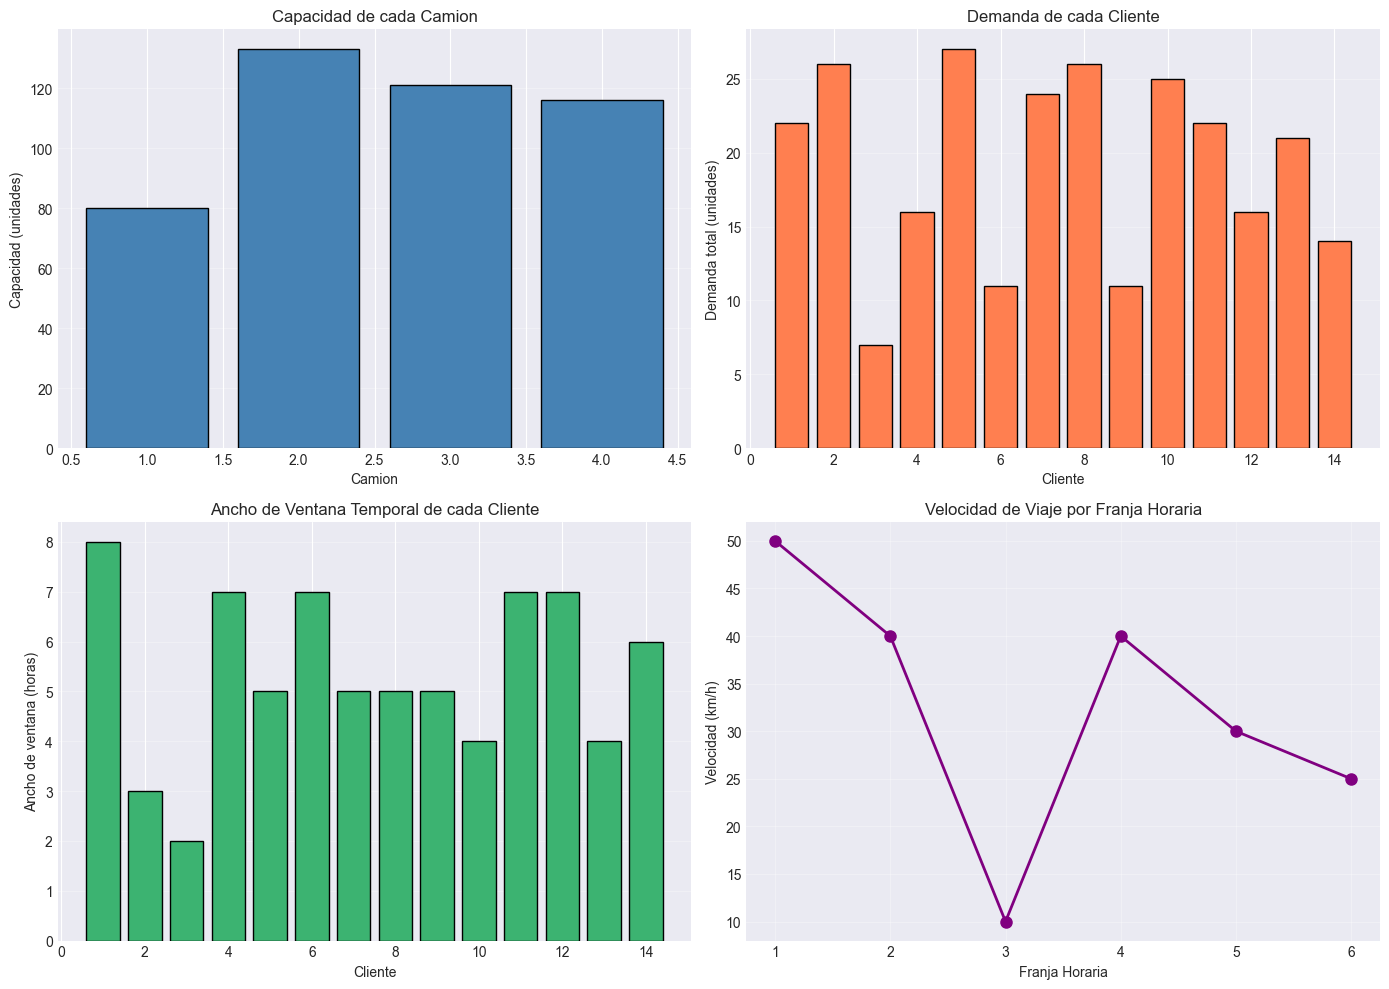


Visualizaciones generadas exitosamente


In [36]:
# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de capacidades
ax = axes[0, 0]
capacities = [vrp_data.Cap.get(t, 0) for t in range(1, vrp_data.num_trucks + 1)]
ax.bar(range(1, vrp_data.num_trucks + 1), capacities, color='steelblue', edgecolor='black')
ax.set_xlabel('Camion')
ax.set_ylabel('Capacidad (unidades)')
ax.set_title('Capacidad de cada Camion')
ax.grid(axis='y', alpha=0.3)

# 2. Distribución de demandas de clientes
ax = axes[0, 1]
demandas = [vrp_data.DemE.get(c, 0) + vrp_data.DemR.get(c, 0) for c in range(1, vrp_data.num_clients + 1)]
ax.bar(range(1, vrp_data.num_clients + 1), demandas, color='coral', edgecolor='black')
ax.set_xlabel('Cliente')
ax.set_ylabel('Demanda total (unidades)')
ax.set_title('Demanda de cada Cliente')
ax.grid(axis='y', alpha=0.3)

# 3. Distribución de anchos de ventana
ax = axes[1, 0]
widths = [vrp_data.MaxDC.get(c, 0) - vrp_data.MinDC.get(c, 0) for c in range(1, vrp_data.num_clients + 1)]
ax.bar(range(1, vrp_data.num_clients + 1), widths, color='mediumseagreen', edgecolor='black')
ax.set_xlabel('Cliente')
ax.set_ylabel('Ancho de ventana (horas)')
ax.set_title('Ancho de Ventana Temporal de cada Cliente')
ax.grid(axis='y', alpha=0.3)

# 4. Velocidades por franja
ax = axes[1, 1]
velocidades = [vrp_data.v.get(f, 0) for f in range(1, vrp_data.num_time_windows + 1)]
ax.plot(range(1, vrp_data.num_time_windows + 1), velocidades, marker='o', linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Franja Horaria')
ax.set_ylabel('Velocidad (km/h)')
ax.set_title('Velocidad de Viaje por Franja Horaria')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(1, vrp_data.num_time_windows + 1))

plt.tight_layout()
plt.show()

print('\nVisualizaciones generadas exitosamente')

---

# PASO 4: CONFIGURACION DEL ALGORITMO GENETICO

En esta sección se definen los parámetros del algoritmo genético, se implementan estructuras de solución, funciones de evaluación y restricciones.

## Parámetros del Algoritmo Genético

Los parámetros del GA controlan cómo se ejecuta la búsqueda. Definimos una población de 100 individuos que evolucionan durante 500 generaciones. La selección por torneo compara 3 individuos aleatorios y elige el mejor, favoreciendo soluciones mejores. El cruzamiento ocurre con probabilidad 85% para generar descendientes que combinen características de buenos padres. La mutación con probabilidad 10% introduce variabilidad mediante intercambios aleatorios de clientes. El elitismo preserva los 2 mejores individuos sin cambios. La búsqueda local 2-opt mejora el 30% de las rutas cada generación. El algoritmo se detiene si no hay mejora en 60 generaciones consecutivas.

In [37]:
# Parámetros del Algoritmo Genético
class GAParameters:
    def __init__(self):
        self.population_size = 100  # Tamaño de población
        self.max_generations = 500  # Máximo número de generaciones
        self.tournament_k = 3  # Tamaño de torneo para selección
        self.crossover_prob = 0.85  # Probabilidad de cruzamiento
        self.mutation_prob = 0.10  # Probabilidad de mutación
        self.elite_size = 2  # Número de soluciones élite a conservar
        self.improvement_window = 60  # Generaciones sin mejora para detener
        self.diversity_check_freq = 50  # Frecuencia de revisión de diversidad
        self.diversity_threshold = 0.80  # Umbral de similitud para regenerar
        self.local_search_rate = 0.30  # Porcentaje de rutas con 2-opt
        
ga_params = GAParameters()

print('PARAMETROS DEL ALGORITMO GENETICO:')
print(f'  Tamaño de población: {ga_params.population_size}')
print(f'  Máximo de generaciones: {ga_params.max_generations}')
print(f'  Tamaño de torneo: {ga_params.tournament_k}')
print(f'  Probabilidad de cruzamiento: {ga_params.crossover_prob}')
print(f'  Probabilidad de mutación: {ga_params.mutation_prob}')
print(f'  Tamaño de élite: {ga_params.elite_size}')
print(f'  Ventana de mejora (sin cambio): {ga_params.improvement_window} gen')
print(f'  Frecuencia de diversidad: cada {ga_params.diversity_check_freq} gen')
print(f'  Umbral de similitud: {ga_params.diversity_threshold}')
print(f'  Porcentaje local search 2-opt: {ga_params.local_search_rate*100:.0f}%')

PARAMETROS DEL ALGORITMO GENETICO:
  Tamaño de población: 100
  Máximo de generaciones: 500
  Tamaño de torneo: 3
  Probabilidad de cruzamiento: 0.85
  Probabilidad de mutación: 0.1
  Tamaño de élite: 2
  Ventana de mejora (sin cambio): 60 gen
  Frecuencia de diversidad: cada 50 gen
  Umbral de similitud: 0.8
  Porcentaje local search 2-opt: 30%


## Estructura de Solución (Individuo)

In [38]:
class Individual:
    """Representa un individuo (solución) en la población"""
    
    def __init__(self, vrp_data, routes=None, fitness=None):
        self.vrp_data = vrp_data
        if routes is None:
            self.routes = self.generate_random()
        else:
            self.routes = routes  # Lista de listas: cada sublista es una ruta de un camión
        
        self.fitness = fitness if fitness is not None else self.calculate_fitness()
    
    def generate_random(self):
        """Genera una solución aleatoria válida respetando capacidad"""
        routes = [[] for _ in range(self.vrp_data.num_trucks)]
        
        # Lista de todos los clientes
        unvisited = list(range(1, self.vrp_data.num_clients + 1))
        np.random.shuffle(unvisited)
        
        for client in unvisited:
            # Encontrar camión con espacio disponible
            dem_e = self.vrp_data.DemE.get(client, 0)
            dem_r = self.vrp_data.DemR.get(client, 0)
            total_demand = dem_e + dem_r
            
            # Intentar asignar a un camión aleatorio con capacidad
            truck_options = []
            for truck in range(self.vrp_data.num_trucks):
                current_load = sum(self.vrp_data.DemE.get(c, 0) + self.vrp_data.DemR.get(c, 0) 
                                 for c in routes[truck])
                if current_load + total_demand <= self.vrp_data.Cap.get(truck + 1, 0):
                    truck_options.append(truck)
            
            if truck_options:
                truck = np.random.choice(truck_options)
                routes[truck].append(client)
            else:
                # Si no hay opción, forzar al primero con mayor capacidad disponible
                best_truck = 0
                best_space = 0
                for truck in range(self.vrp_data.num_trucks):
                    current_load = sum(self.vrp_data.DemE.get(c, 0) + self.vrp_data.DemR.get(c, 0) 
                                     for c in routes[truck])
                    available = self.vrp_data.Cap.get(truck + 1, 0) - current_load
                    if available > best_space:
                        best_space = available
                        best_truck = truck
                routes[best_truck].append(client)
        
        return routes
    
    def calculate_fitness(self):
        """Calcula el fitness (objetivo Z) de la solución"""
        fitness = 0
        
        # PENALIZACION FUERTE por clientes no asignados
        assigned_clients = set()
        for truck in range(self.vrp_data.num_trucks):
            assigned_clients.update(self.routes[truck])
        
        total_clients = self.vrp_data.num_clients
        unassigned_clients = total_clients - len(assigned_clients)
        
        # Penalización muy alta: 10000 por cada cliente no asignado
        if unassigned_clients > 0:
            fitness += unassigned_clients * 10000
        
        for truck in range(self.vrp_data.num_trucks):
            route = self.routes[truck]
            
            if len(route) == 0:
                continue  # Camión sin asignaciones
            
            # Costo del camión según contrato
            truck_num = truck + 1
            is_hora = self.vrp_data.esHora.get(truck_num, 0)
            is_f6 = self.vrp_data.esF6.get(truck_num, 0)
            is_f12 = self.vrp_data.esF12.get(truck_num, 0)
            
            # Calcular tiempo total y costo
            current_time = self.vrp_data.tinic.get(1, 0)  # Hora de inicio del primer período
            total_distance = 0
            
            # Desde depósito al primer cliente
            prev = 0
            for client in route:
                dist = self.vrp_data.get_distance(prev, client)
                total_distance += dist
                prev = client
            
            # De último cliente al depósito
            dist = self.vrp_data.get_distance(prev, 0)
            total_distance += dist
            
            # Tiempo de viaje (usar franja horaria 1 como promedio)
            travel_time = total_distance / self.vrp_data.v.get(1, 40)  # velocidad en franja 1
            
            # Tiempo de servicio
            service_time = sum(self.vrp_data.TS.get(client, 0) for client in route)
            
            total_time = travel_time + service_time
            
            # Costo según contrato
            if is_hora:
                truck_cost = total_time * self.vrp_data.CH.get(truck_num, 0)
            elif is_f6:
                truck_cost = self.vrp_data.CF6.get(truck_num, 0)
            elif is_f12:
                truck_cost = self.vrp_data.CF12.get(truck_num, 0)
            else:
                truck_cost = 0
            
            fitness += truck_cost
            
            # Penalizaciones por ventanas de tiempo
            current_time = 8.0  # Inicio a las 8:00 AM
            for client in route:
                dist_to_client = self.vrp_data.get_distance(0, client)
                travel = dist_to_client / self.vrp_data.v.get(1, 40)
                current_time += travel
                
                min_dc = self.vrp_data.MinDC.get(client, 0)
                max_dc = self.vrp_data.MaxDC.get(client, 0)
                service = self.vrp_data.TS.get(client, 0)
                
                # Penalización por llegar temprano
                if current_time < min_dc:
                    if self.vrp_data.is_critical(client):
                        fitness += (min_dc - current_time) * self.vrp_data.pcmin_c
                    else:
                        fitness += (min_dc - current_time) * self.vrp_data.pcmin_nc
                    current_time = min_dc
                
                # Penalización por llegar tarde
                if current_time > max_dc:
                    if self.vrp_data.is_critical(client):
                        fitness += (current_time - max_dc) * self.vrp_data.pcmax_c
                    else:
                        fitness += (current_time - max_dc) * self.vrp_data.pcmax_nc
                
                current_time += service
            
            # Penalización por regreso tardío
            if current_time > self.vrp_data.tlim:
                fitness += (current_time - self.vrp_data.tlim) * self.vrp_data.preg
        
        self.fitness = fitness
        return fitness
    
    def copy(self):
        """Crear una copia profunda del individuo"""
        new_routes = [route.copy() for route in self.routes]
        return Individual(self.vrp_data, routes=new_routes, fitness=self.fitness)

print('Clase Individual definida exitosamente')

Clase Individual definida exitosamente


## Inicialización de Población

In [39]:
def initialize_population(vrp_data, pop_size):
    """Inicializa la población con individuos aleatorios"""
    population = []
    for _ in range(pop_size):
        individual = Individual(vrp_data)
        individual.calculate_fitness()
        population.append(individual)
    return population

# Generar población inicial
print('Inicializando población...')
population = initialize_population(vrp_data, ga_params.population_size)

# Estadísticas iniciales
fitnesses = [ind.fitness for ind in population]
print(f'\nESTADISTICAS DE POBLACION INICIAL:')
print(f'  Mejor fitness: {min(fitnesses):.2f}')
print(f'  Peor fitness: {max(fitnesses):.2f}')
print(f'  Fitness promedio: {np.mean(fitnesses):.2f}')
print(f'  Desviación estándar: {np.std(fitnesses):.2f}')

Inicializando población...

ESTADISTICAS DE POBLACION INICIAL:
  Mejor fitness: 1548.46
  Peor fitness: 3028.60
  Fitness promedio: 2357.55
  Desviación estándar: 286.29


---

# PASO 5: OPERADORES GENETICOS

En esta sección se implementan los operadores genéticos: selección por torneo, cruzamiento basado en rutas (RBX), mutación (SWAP e INSERT) y búsqueda local (2-opt).

## Operador de Selección (Torneo)

In [40]:
def tournament_selection(population, tournament_k):
    """Selecciona un individuo mediante selección por torneo"""
    tournament = np.random.choice(len(population), size=tournament_k, replace=False)
    best_idx = min(tournament, key=lambda idx: population[idx].fitness)
    return population[best_idx].copy()

print('Operador de selección por torneo implementado')

Operador de selección por torneo implementado


## Operador de Cruzamiento (Route-Based Crossover - RBX)

In [41]:
def crossover_rbx(parent1, parent2, vrp_data):
    """
    Cruzamiento basado en rutas (RBX):
    Intercambia rutas completas entre dos padres
    """
    offspring = Individual(vrp_data)
    
    # Copiar rutas del primer padre
    offspring.routes = [route.copy() for route in parent1.routes]
    
    # Seleccionar aleatoriamente un número de rutas del segundo padre
    num_routes_to_exchange = np.random.randint(1, vrp_data.num_trucks // 2 + 1)
    routes_to_exchange = np.random.choice(vrp_data.num_trucks, size=num_routes_to_exchange, replace=False)
    
    # Intercambiar rutas
    for truck_idx in routes_to_exchange:
        offspring.routes[truck_idx] = parent2.routes[truck_idx].copy()
    
    # Reparar solución si hay violaciones de capacidad
    offspring = repair_solution(offspring, vrp_data)
    offspring.calculate_fitness()
    
    return offspring

def repair_solution(individual, vrp_data):
    """Repara una solución que viola restricciones de capacidad y asegura que TODOS los clientes se asignen"""
    
    # Paso 1: Identificar clientes asignados y no asignados
    assigned_clients = set()
    for truck in range(vrp_data.num_trucks):
        assigned_clients.update(individual.routes[truck])
    
    unassigned_clients = [c for c in range(1, vrp_data.num_clients + 1) if c not in assigned_clients]
    
    # Paso 2: Reparar violaciones de capacidad
    for truck in range(vrp_data.num_trucks):
        route = individual.routes[truck]
        truck_capacity = vrp_data.Cap.get(truck + 1, 0)
        current_load = sum(vrp_data.DemE.get(c, 0) + vrp_data.DemR.get(c, 0) for c in route)
        
        # Si hay sobrecarga, mover clientes a otro camión
        clients_to_remove = []
        while current_load > truck_capacity and len(route) > 0:
            client_to_remove = route.pop()
            dem = vrp_data.DemE.get(client_to_remove, 0) + vrp_data.DemR.get(client_to_remove, 0)
            current_load -= dem
            clients_to_remove.append(client_to_remove)
            unassigned_clients.append(client_to_remove)
        
        individual.routes[truck] = route
    
    # Paso 3: GARANTIZAR que todos los clientes se asignen (incluso si hay sobrecarga)
    for client in unassigned_clients:
        dem = vrp_data.DemE.get(client, 0) + vrp_data.DemR.get(client, 0)
        assigned = False
        
        # Intentar asignar a un camión con capacidad disponible
        for truck in range(vrp_data.num_trucks):
            current_load = sum(vrp_data.DemE.get(c, 0) + vrp_data.DemR.get(c, 0) 
                             for c in individual.routes[truck])
            truck_capacity = vrp_data.Cap.get(truck + 1, 0)
            
            if current_load + dem <= truck_capacity:
                individual.routes[truck].append(client)
                assigned = True
                break
        
        # Si no hay espacio, asignar al camión con menor carga
        if not assigned:
            best_truck = 0
            best_load = float('inf')
            
            for truck in range(vrp_data.num_trucks):
                current_load = sum(vrp_data.DemE.get(c, 0) + vrp_data.DemR.get(c, 0) 
                                 for c in individual.routes[truck])
                if current_load < best_load:
                    best_load = current_load
                    best_truck = truck
            
            individual.routes[best_truck].append(client)
    
    return individual

print('Operador de cruzamiento (RBX) implementado')

Operador de cruzamiento (RBX) implementado


## Operador de Mutación (SWAP e INSERT)

In [42]:
def mutate_swap(individual, vrp_data):
    """
    Mutación SWAP: intercambia dos clientes en la solución
    Probabilidad: 70%
    """
    # Obtener todos los clientes asignados
    all_clients = []
    client_positions = {}  # (truck, position_in_route)
    
    for truck in range(vrp_data.num_trucks):
        for pos, client in enumerate(individual.routes[truck]):
            all_clients.append(client)
            client_positions[client] = (truck, pos)
    
    if len(all_clients) < 2:
        return individual
    
    # Seleccionar dos clientes aleatorios
    client1_idx = np.random.randint(0, len(all_clients))
    client2_idx = np.random.randint(0, len(all_clients))
    
    if client1_idx != client2_idx:
        client1 = all_clients[client1_idx]
        client2 = all_clients[client2_idx]
        
        truck1, pos1 = client_positions[client1]
        truck2, pos2 = client_positions[client2]
        
        # Intercambiar clientes
        individual.routes[truck1][pos1], individual.routes[truck2][pos2] = \
            individual.routes[truck2][pos2], individual.routes[truck1][pos1]
    
    return individual

def mutate_insert(individual, vrp_data):
    """
    Mutación INSERT: remueve un cliente y lo inserta en otra posición
    Probabilidad: 20%
    """
    # Obtener un cliente aleatorio
    all_clients = []
    client_positions = {}
    
    for truck in range(vrp_data.num_trucks):
        for pos, client in enumerate(individual.routes[truck]):
            all_clients.append(client)
            client_positions[client] = (truck, pos)
    
    if len(all_clients) < 1:
        return individual
    
    # Seleccionar cliente a mover
    client_idx = np.random.randint(0, len(all_clients))
    client = all_clients[client_idx]
    truck, pos = client_positions[client]
    
    # Remover cliente
    individual.routes[truck].pop(pos)
    
    # Seleccionar nueva posición aleatoria (puede ser en otra ruta)
    new_truck = np.random.randint(0, vrp_data.num_trucks)
    new_pos = np.random.randint(0, len(individual.routes[new_truck]) + 1)
    
    # Verificar capacidad antes de insertar
    dem = vrp_data.DemE.get(client, 0) + vrp_data.DemR.get(client, 0)
    current_load = sum(vrp_data.DemE.get(c, 0) + vrp_data.DemR.get(c, 0) 
                      for c in individual.routes[new_truck])
    truck_capacity = vrp_data.Cap.get(new_truck + 1, 0)
    
    if current_load + dem <= truck_capacity:
        individual.routes[new_truck].insert(new_pos, client)
    else:
        # Revertir si no hay capacidad
        individual.routes[truck].insert(pos, client)
    
    return individual

def mutate(individual, vrp_data, mutation_prob):
    """Aplica mutación a un individuo (70% SWAP, 20% INSERT, 10% no cambio)"""
    if np.random.random() < mutation_prob:
        rand = np.random.random()
        if rand < 0.7:
            individual = mutate_swap(individual, vrp_data)
        elif rand < 0.9:
            individual = mutate_insert(individual, vrp_data)
        # Si rand >= 0.9, no se realiza mutación
    
    individual.calculate_fitness()
    return individual

print('Operadores de mutación (SWAP e INSERT) implementados')

Operadores de mutación (SWAP e INSERT) implementados


## Búsqueda Local: 2-opt

In [43]:
def two_opt_route(route, vrp_data, max_iterations=100):
    """
    Aplica búsqueda local 2-opt a una ruta individual
    Intenta mejorar intercambiando pares de aristas
    """
    improved = True
    iterations = 0
    
    while improved and iterations < max_iterations:
        improved = False
        iterations += 1
        
        for i in range(len(route) - 1):
            for j in range(i + 2, len(route)):
                # Calcular distancia actual
                dist_current = (vrp_data.get_distance(0 if i == 0 else route[i-1], route[i]) +
                               vrp_data.get_distance(route[j], 0 if j == len(route) - 1 else route[j+1]))
                
                # Calcular distancia después del intercambio
                dist_new = (vrp_data.get_distance(0 if i == 0 else route[i-1], route[j]) +
                           vrp_data.get_distance(route[i], 0 if j == len(route) - 1 else route[j+1]))
                
                if dist_new < dist_current:
                    # Invertir segmento entre i y j
                    route[i:j+1] = reversed(route[i:j+1])
                    improved = True
                    break
            
            if improved:
                break
    
    return route

def apply_local_search(individual, vrp_data, local_search_rate):
    """Aplica búsqueda local 2-opt a una proporción de rutas"""
    num_routes_to_improve = max(1, int(vrp_data.num_trucks * local_search_rate))
    
    # Seleccionar rutas para mejorar (preferentemente las no vacías)
    non_empty_trucks = [t for t in range(vrp_data.num_trucks) if len(individual.routes[t]) > 1]
    
    if non_empty_trucks:
        trucks_to_improve = np.random.choice(non_empty_trucks, 
                                            size=min(num_routes_to_improve, len(non_empty_trucks)), 
                                            replace=False)
    else:
        trucks_to_improve = []
    
    for truck in trucks_to_improve:
        individual.routes[truck] = two_opt_route(individual.routes[truck], vrp_data)
    
    individual.calculate_fitness()
    return individual

print('Búsqueda local 2-opt implementada')

Búsqueda local 2-opt implementada


---

# PASO 6: EJECUCION DEL ALGORITMO GENETICO

En esta sección se implementa el ciclo principal del algoritmo genético con elitismo, control de diversidad y criterios de parada.

## Función Principal del Algoritmo Genético

In [44]:
def genetic_algorithm(vrp_data, ga_params, verbose=True):
    """
    Ejecuta el algoritmo genético completo
    
    Retorna:
    - best_solution: Mejor individuo encontrado
    - best_fitness: Fitness del mejor individuo
    - history: Historial de evolución (best y promedio por generación)
    """
    
    # Inicializar población
    population = initialize_population(vrp_data, ga_params.population_size)
    best_solution = min(population, key=lambda x: x.fitness).copy()
    
    history = {
        'generation': [],
        'best_fitness': [],
        'avg_fitness': [],
        'worst_fitness': []
    }
    
    generations_without_improvement = 0
    start_time = time.time()
    
    if verbose:
        print('='*80)
        print('INICIANDO ALGORITMO GENETICO')
        print('='*80)
        print(f'Generación 0: Best={best_solution.fitness:.2f}')
    
    for generation in range(ga_params.max_generations):
        
        # Ordenar población por fitness
        population.sort(key=lambda x: x.fitness)
        
        # Actualizar mejor solución
        current_best = population[0]
        if current_best.fitness < best_solution.fitness:
            best_solution = current_best.copy()
            generations_without_improvement = 0
        else:
            generations_without_improvement += 1
        
        # Registrar estadísticas
        fitnesses = [ind.fitness for ind in population]
        history['generation'].append(generation)
        history['best_fitness'].append(min(fitnesses))
        history['avg_fitness'].append(np.mean(fitnesses))
        history['worst_fitness'].append(max(fitnesses))
        
        # Criterio de parada: sin mejora en N generaciones
        if generations_without_improvement >= ga_params.improvement_window:
            if verbose:
                print(f'\nAlgoritmo detenido en generación {generation}')
                print(f'Sin mejora en {ga_params.improvement_window} generaciones')
            break
        
        # Control de diversidad cada N generaciones
        if generation > 0 and generation % ga_params.diversity_check_freq == 0:
            diversity_score = calculate_diversity(population)
            
            if diversity_score > ga_params.diversity_threshold:
                # Regenerar 30% de la población (excepto élite)
                num_to_regenerate = int(ga_params.population_size * 0.30)
                for i in range(ga_params.elite_size, ga_params.elite_size + num_to_regenerate):
                    if i < len(population):
                        population[i] = Individual(vrp_data)
                        population[i].calculate_fitness()
        
        # Crear nueva población
        new_population = []
        
        # Elitismo: mantener mejores soluciones
        for i in range(ga_params.elite_size):
            new_population.append(population[i].copy())
        
        # Generar resto de población
        while len(new_population) < ga_params.population_size:
            
            # Selección de padres
            parent1 = tournament_selection(population, ga_params.tournament_k)
            parent2 = tournament_selection(population, ga_params.tournament_k)
            
            # Cruzamiento
            if np.random.random() < ga_params.crossover_prob:
                offspring = crossover_rbx(parent1, parent2, vrp_data)
            else:
                offspring = parent1.copy()
            
            # Mutación
            offspring = mutate(offspring, vrp_data, ga_params.mutation_prob)
            
            # Búsqueda local (2-opt)
            offspring = apply_local_search(offspring, vrp_data, ga_params.local_search_rate)
            
            new_population.append(offspring)
        
        # Actualizar población
        population = new_population[:ga_params.population_size]
        
        # Mostrar progreso
        if verbose and (generation + 1) % 50 == 0:
            current_fitness = min([ind.fitness for ind in population])
            avg_fitness = np.mean([ind.fitness for ind in population])
            print(f'Generación {generation + 1}: Best={current_fitness:.2f}, Avg={avg_fitness:.2f}, SinMejora={generations_without_improvement}')
    
    elapsed_time = time.time() - start_time
    
    if verbose:
        print('='*80)
        print(f'ALGORITMO COMPLETADO')
        print(f'Mejor solución encontrada: {best_solution.fitness:.2f}')
        print(f'Tiempo total: {elapsed_time:.2f} segundos')
        print('='*80)
    
    return best_solution, best_solution.fitness, history

def calculate_diversity(population):
    """Calcula similitud promedio de la población (0=diversa, 1=homogénea)"""
    if len(population) < 2:
        return 0
    
    total_similarity = 0
    count = 0
    
    for i in range(min(10, len(population))):  # Comparar solo primeros 10 por eficiencia
        for j in range(i + 1, min(10, len(population))):
            # Contar clientes en común entre soluciones i y j
            clients_i = set()
            clients_j = set()
            
            for route in population[i].routes:
                clients_i.update(route)
            for route in population[j].routes:
                clients_j.update(route)
            
            # Calcular Jaccard similarity
            if len(clients_i) > 0 or len(clients_j) > 0:
                intersection = len(clients_i & clients_j)
                union = len(clients_i | clients_j)
                similarity = intersection / union if union > 0 else 0
                total_similarity += similarity
                count += 1
    
    diversity = total_similarity / count if count > 0 else 0
    return diversity

print('Función principal del algoritmo genético implementada')

Función principal del algoritmo genético implementada


## Ejecución del Algoritmo Genético

In [45]:
print('\n' + '='*80)
print('EJECUTANDO ALGORITMO GENETICO COMPLETO')
print('='*80 + '\n')

# Ejecutar el algoritmo
best_solution, best_fitness, history = genetic_algorithm(vrp_data, ga_params, verbose=True)

print('\nRESULTADOS FINALES:')
print(f'  Mejor fitness encontrado: {best_fitness:.2f}')
print(f'  Número de generaciones ejecutadas: {len(history["generation"])}')
print(f'  Fitness inicial (población aleatoria): {history["best_fitness"][0]:.2f}')
print(f'  Mejora porcentual: {100*(history["best_fitness"][0] - best_fitness)/history["best_fitness"][0]:.2f}%')


EJECUTANDO ALGORITMO GENETICO COMPLETO

INICIANDO ALGORITMO GENETICO
Generación 0: Best=1645.38
Generación 50: Best=1296.12, Avg=1449.77, SinMejora=7
Generación 100: Best=1279.96, Avg=1415.45, SinMejora=7
Generación 150: Best=1279.96, Avg=1329.67, SinMejora=57

Algoritmo detenido en generación 152
Sin mejora en 60 generaciones
ALGORITMO COMPLETADO
Mejor solución encontrada: 1279.96
Tiempo total: 10.25 segundos

RESULTADOS FINALES:
  Mejor fitness encontrado: 1279.96
  Número de generaciones ejecutadas: 153
  Fitness inicial (población aleatoria): 1645.38
  Mejora porcentual: 22.21%


## Visualización de Convergencia

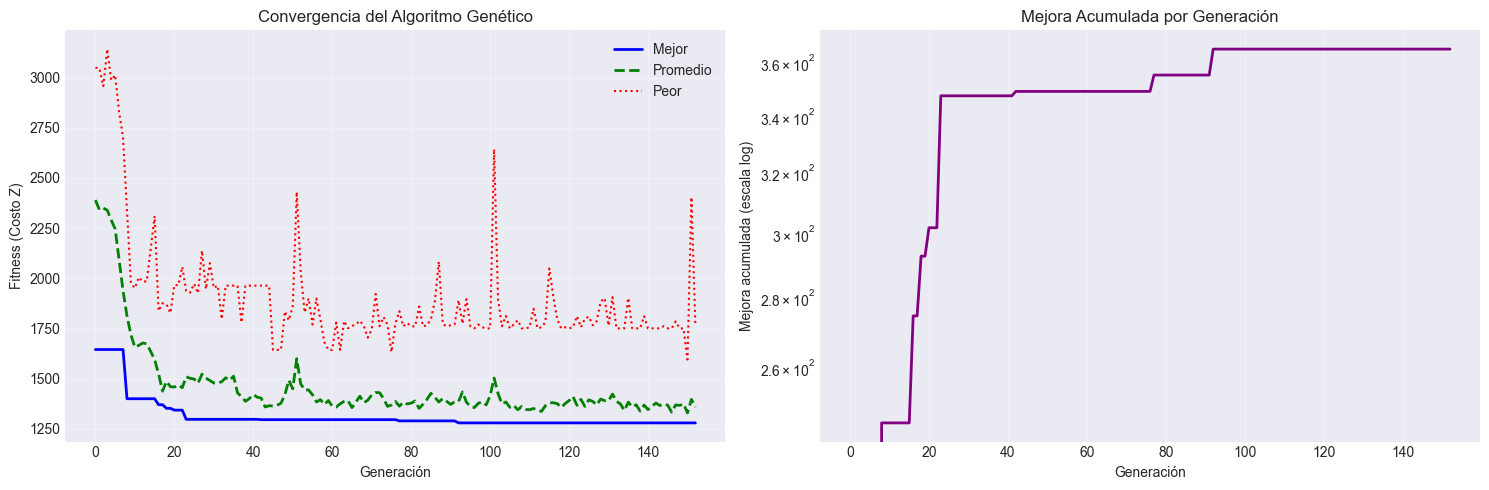

Gráficas de convergencia generadas exitosamente


In [46]:
# Crear gráficas de convergencia
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica 1: Evolución del mejor fitness
ax = axes[0]
ax.plot(history['generation'], history['best_fitness'], 'b-', linewidth=2, label='Mejor')
ax.plot(history['generation'], history['avg_fitness'], 'g--', linewidth=2, label='Promedio')
ax.plot(history['generation'], history['worst_fitness'], 'r:', linewidth=1.5, label='Peor')
ax.set_xlabel('Generación')
ax.set_ylabel('Fitness (Costo Z)')
ax.set_title('Convergencia del Algoritmo Genético')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfica 2: Mejora logarítmica
ax = axes[1]
best_fitnesses = history['best_fitness']
improvement = [best_fitnesses[0] - f for f in best_fitnesses]
ax.semilogy(history['generation'], improvement, 'purple', linewidth=2)
ax.set_xlabel('Generación')
ax.set_ylabel('Mejora acumulada (escala log)')
ax.set_title('Mejora Acumulada por Generación')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('Gráficas de convergencia generadas exitosamente')

---

# PASO 7: INTENSIFICACION Y MEJORA LOCAL

La búsqueda local intensificada refina la mejor solución encontrada. Se aplica 2-opt exhaustivo a todas las rutas no vacías hasta que no haya mejora.

In [47]:
print('Aplicando búsqueda local intensificada a la mejor solución...\n')

# Aplicar búsqueda local exhaustiva a todas las rutas
best_solution_refined = best_solution.copy()
for truck in range(vrp_data.num_trucks):
    if len(best_solution_refined.routes[truck]) > 1:
        best_solution_refined.routes[truck] = two_opt_route(
            best_solution_refined.routes[truck], 
            vrp_data, 
            max_iterations=500
        )

best_solution_refined.calculate_fitness()

print(f'Fitness después de intensificación: {best_solution_refined.fitness:.2f}')
print(f'Mejora adicional: {best_solution.fitness - best_solution_refined.fitness:.2f}')

Aplicando búsqueda local intensificada a la mejor solución...

Fitness después de intensificación: 1279.96
Mejora adicional: 0.00


---

# PASO 8: RESULTADOS Y ANALISIS FINAL

Los resultados finales muestran la efectividad del algoritmo genético en resolver el problema VRP. Se comparan la solución inicial aleatoria, la mejor encontrada por el GA, y la solución refinada.

In [48]:
print('='*80)
print('RESUMEN FINAL DE RESULTADOS')
print('='*80)

# Comparación de soluciones
fitness_inicial = history['best_fitness'][0]
fitness_ga = best_solution.fitness
fitness_final = best_solution_refined.fitness

mejora_ga = ((fitness_inicial - fitness_ga) / fitness_inicial) * 100
mejora_total = ((fitness_inicial - fitness_final) / fitness_inicial) * 100
mejora_intensificacion = ((fitness_ga - fitness_final) / fitness_ga) * 100 if fitness_ga > fitness_final else 0

# Validar que todos los clientes están asignados
assigned_clients = set()
for truck in range(vrp_data.num_trucks):
    assigned_clients.update(best_solution_refined.routes[truck])

total_clients = vrp_data.num_clients
unassigned = total_clients - len(assigned_clients)

print(f'\nSOLUCION INICIAL (población aleatoria):')
print(f'  Fitness: {fitness_inicial:.2f}')

print(f'\nSOLUCION DEL GA (después de {len(history["generation"])} generaciones):')
print(f'  Fitness: {fitness_ga:.2f}')
print(f'  Mejora vs inicial: {mejora_ga:.2f}%')

print(f'\nSOLUCION REFINADA (con búsqueda local intensificada):')
print(f'  Fitness: {fitness_final:.2f}')
print(f'  Mejora vs GA: {mejora_intensificacion:.2f}%')
print(f'  Mejora total vs inicial: {mejora_total:.2f}%')

print(f'\nINFORMACION DE LA SOLUCION FINAL:')
print(f'  Número de generaciones ejecutadas: {len(history["generation"])}')
print(f'  Criterio de parada: Sin mejora en 60 generaciones consecutivas')
print(f'  Clientes atendidos: {len(assigned_clients)}/{total_clients}')
if unassigned > 0:
    print(f'  [ADVERTENCIA] {unassigned} cliente(s) SIN ATENDER')
else:
    print(f'  [OK] TODOS LOS CLIENTES ATENDIDOS')
print(f'  Costo operacional total (Z): {fitness_final:.2f}')

print(f'\nRESUMEN DE CAPACIDADES Y UTILIZACION:')
total_capacity = sum([vrp_data.Cap.get(t + 1, 0) for t in range(vrp_data.num_trucks)])
total_cargo = 0
trucks_used = 0

for truck in range(vrp_data.num_trucks):
    route = best_solution_refined.routes[truck]
    if len(route) > 0:
        trucks_used += 1
        carga = sum(vrp_data.DemE.get(c, 0) + vrp_data.DemR.get(c, 0) for c in route)
        total_cargo += carga

print(f'  Camiones utilizados: {trucks_used}/{vrp_data.num_trucks}')
print(f'  Carga total transportada: {total_cargo} unidades')
print(f'  Capacidad total de flota: {total_capacity} unidades')
print(f'  Utilización promedio: {100*total_cargo/total_capacity:.1f}%')

print(f'\nDETALLE DE RUTAS:')
for truck in range(vrp_data.num_trucks):
    route = best_solution_refined.routes[truck]
    if len(route) > 0:
        capacidad = vrp_data.Cap.get(truck + 1, 0)
        carga = sum(vrp_data.DemE.get(c, 0) + vrp_data.DemR.get(c, 0) for c in route)
        utilizacion = (carga / capacidad) * 100
        
        # Calcular si hay sobrecarga
        status = '[OK]' if carga <= capacidad else '[SOBRECARGA]'
        
        print(f'\n  Camión {truck+1}: {status}')
        print(f'    Clientes: {len(route)} ({route})')
        print(f'    Carga: {carga}/{capacidad} unidades ({utilizacion:.1f}%)')
    else:
        print(f'\n  Camión {truck+1}: SIN ASIGNACIONES')

print('\n' + '='*80)
print('RESUMEN ESTADISTICO')
print('='*80)
print(f'  Fitness inicial: {fitness_inicial:.2f}')
print(f'  Fitness final:   {fitness_final:.2f}')
print(f'  Mejora total:    {mejora_total:.2f}%')
print(f'  Generaciones:    {len(history["generation"])}')
print(f'  Estado: {"[EXITOSO]" if unassigned == 0 else "[INCOMPLETO]"}')
print('='*80)

RESUMEN FINAL DE RESULTADOS

SOLUCION INICIAL (población aleatoria):
  Fitness: 1645.38

SOLUCION DEL GA (después de 153 generaciones):
  Fitness: 1279.96
  Mejora vs inicial: 22.21%

SOLUCION REFINADA (con búsqueda local intensificada):
  Fitness: 1279.96
  Mejora vs GA: 0.00%
  Mejora total vs inicial: 22.21%

INFORMACION DE LA SOLUCION FINAL:
  Número de generaciones ejecutadas: 153
  Criterio de parada: Sin mejora en 60 generaciones consecutivas
  Clientes atendidos: 14/14
  [OK] TODOS LOS CLIENTES ATENDIDOS
  Costo operacional total (Z): 1279.96

RESUMEN DE CAPACIDADES Y UTILIZACION:
  Camiones utilizados: 3/4
  Carga total transportada: 282.0 unidades
  Capacidad total de flota: 450.0 unidades
  Utilización promedio: 62.7%

DETALLE DE RUTAS:

  Camión 1: SIN ASIGNACIONES

  Camión 2: [OK]
    Clientes: 6 ([2, 13, 5, 1, 12, 14])
    Carga: 126.0/133.0 unidades (94.7%)

  Camión 3: [OK]
    Clientes: 2 ([9, 11])
    Carga: 33.0/121.0 unidades (27.3%)

  Camión 4: [SOBRECARGA]
    C